# SAM Fine-Tuning in ISIC 2018

**Autores:**

- Kauan Mariani Ferreira
- Pedro Henrique Coterli
- Samuel Lima Corrêa

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from segment_anything import sam_model_registry
from tqdm import tqdm 
import os
import copy
import json
import zipfile
import matplotlib.pyplot as plt
import random
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

random.seed(44)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Carregando o modelo SAM

Para os ajustes finos, foi utilizado como modelo inicial a primeira versão do modelo SAM.

In [2]:
if not os.path.exists("/kaggle/working/sam_vit_b_01ec64.pth"):
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    !wget -nv -O sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gih0l8s9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gih0l8s9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
2025-11-21 17:45:18 URL:https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth [375042383/375042383] -> "sam_vit_b_01ec64.pth" [1]


In [3]:
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")

## Carregando os modelos treinados e resultados

In [4]:
if not os.path.exists("/kaggle/working/sam_decoder_finetuned.pth"):
    !gdown "11b_16f6vmHniN_CbbSZJ2J6itLMPZKzA"

    with zipfile.ZipFile("results.zip", "r") as zip_ref:
        zip_ref.extractall(".")
   
    # Remove o zip
    os.remove("results.zip")

    print("Modelos e JSONs extraídos com sucesso.")

else:
    print("Modelos já existem.")

Downloading...
From (original): https://drive.google.com/uc?id=11b_16f6vmHniN_CbbSZJ2J6itLMPZKzA
From (redirected): https://drive.google.com/uc?id=11b_16f6vmHniN_CbbSZJ2J6itLMPZKzA&confirm=t&uuid=793ae3ee-2097-4b3c-9f44-ef29690bd048
To: /kaggle/working/results.zip
100%|████████████████████████████████████████| 697M/697M [00:07<00:00, 87.1MB/s]
Modelos e JSONs extraídos com sucesso.


## Criando os datasets

In [5]:
# Dataset dos dados do ISIC
class ISICDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def _get_box(self, mask):
        # Se for Tensor converte para numpy
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = mask

        # Garante que temos 2 dimensões
        if mask_np.ndim == 3:
            mask_np = mask_np.squeeze()

        # Onde o pixel for branco
        y_indices, x_indices = np.where(mask_np > 0)

        # Se não tivermos lesão
        if len(y_indices) == 0:
            H, W = mask_np.shape
            return np.array([0, 0, W, H])

        # Calcula as bounding boxes
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Random de variação para não ter bounding boxes perfeitas
        H, W = mask_np.shape
        buffer = np.random.randint(0, 20)
        
        x_min = max(0, x_min - buffer)
        x_max = min(W, x_max + buffer)
        y_min = max(0, y_min - buffer)
        y_max = min(H, y_max + buffer)

        return np.array([x_min, y_min, x_max, y_max])

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Pegamos as mascaras
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        # Garante binarização limpa (0 ou 255) antes do transform
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # transformações se existirem
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Gerando a box
        box = self._get_box(mask)

        # Deixa a mask do jeito que queremos
        if isinstance(mask, torch.Tensor):
            mask = mask.float() / 255.0
        else:
            mask = (mask / 255.0).astype(np.float32)
            mask = torch.from_numpy(mask)

        # Adicionando dimensões
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        # Retorna os tamanhos (3,H,W), (1,H,W), (4,)
        return img, mask, box  

    def __len__(self):
        return len(self.image_paths)

In [6]:
# Listas com as imagens de cada conjunto
train_images = sorted(glob.glob("/kaggle/input/isic-2018/data/images/train/*.jpg"))
train_masks = sorted(glob.glob("/kaggle/input/isic-2018/data/annotations/train/*.png"))
val_images = sorted(glob.glob("/kaggle/input/isic-2018/data/images/val/*.jpg"))
val_masks = sorted(glob.glob("/kaggle/input/isic-2018/data/annotations/val/*.png"))
test_images = sorted(glob.glob("/kaggle/input/isic-2018/data/images/test/*.jpg"))
test_masks = sorted(glob.glob("/kaggle/input/isic-2018/data/annotations/test/*.png"))

In [7]:
# Transformações
transform_train = A.Compose([
    A.Resize(1024, 1024),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    # Normalização padrão do SAM
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Resize(1024, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [8]:
# Inicializando os datasets e os dataloaders
train_ds = ISICDataset(train_images, train_masks, transform=transform_train)
val_ds = ISICDataset(val_images, val_masks, transform=transform_val)
test_ds = ISICDataset(test_images, test_masks, transform=transform_val)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

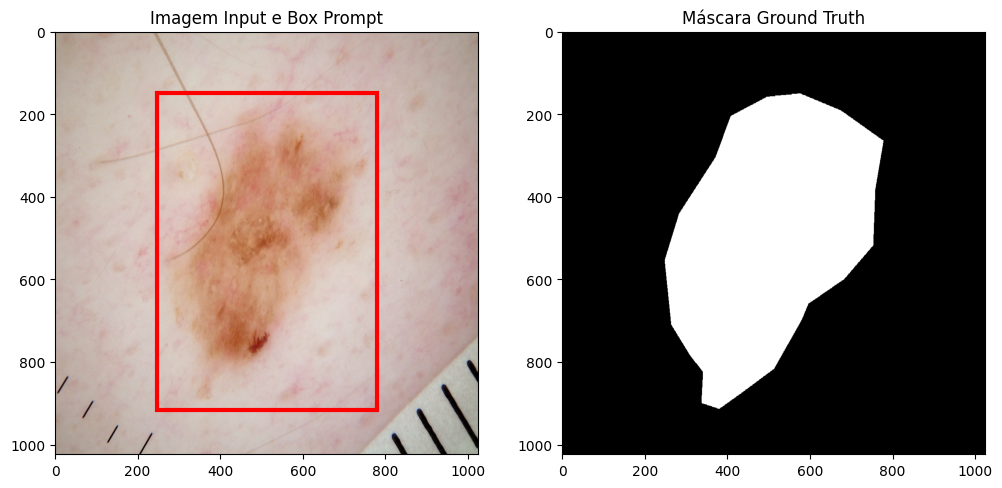

In [9]:
def show_sample(img_tensor, mask_tensor, box):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    mask = mask_tensor.squeeze().cpu().numpy()
    x1, y1, x2, y2 = box[0].numpy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(img)
    ax[0].set_title("Imagem Input e Box Prompt")
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=3)
    ax[0].add_patch(rect)
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Máscara Ground Truth")
    
    plt.show()

# Pega um batch
img_batch, mask_batch, box_batch = next(iter(train_loader))

show_sample(img_batch[0], mask_batch[0], box_batch)

## Função de perda: Dice BCE loss

Essa função de perda foi escolhida para manter-se fiel ao paper original.

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return bce + dice_loss

## Métrica de avaliação: IoU

In [11]:
def calculate_iou(pred_mask, gt_mask):
    pred_mask = (torch.sigmoid(pred_mask) > 0.5).float()
    
    intersection = (pred_mask * gt_mask).sum()
    union = pred_mask.sum() + gt_mask.sum() - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

## Early stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience = 3, min_delta = 0, path = "sam_isic_best"):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_max = -np.Inf

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(val_score, model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"EarlyStopping: {self.counter}/{self.patience} sem melhoria")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.save_checkpoint(val_score, model)
            self.counter = 0

    # Método para salvar o melhor modelo até então
    def save_checkpoint(self, val_score, model):
        torch.save(model.state_dict(), self.path + ".pth")
        self.val_score_max = val_score

## Funções auxiliares de treinamento

In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="Treinando")
    for k, (inputs, masks, boxes) in enumerate(pbar):
        inputs = inputs.to(device)
        masks = masks.to(device)
        boxes = boxes.to(device)

        # Mask encoder
        image_embeddings = model.image_encoder(inputs)
        
        # prompt encoder com a box
        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None,
            boxes=boxes.unsqueeze(1), 
            masks=None,
        )
        
        # Mask decoder
        low_res_masks_list = []
        
        for i in range(len(image_embeddings)):
            # Pegamos a fatia i e adicionamos a dimensão de batch (unsqueeze)
            # Shape vai de (C, H, W) para (1, C, H, W)
            curr_emb = image_embeddings[i].unsqueeze(0)
            curr_sparse = sparse_embeddings[i].unsqueeze(0)
            curr_dense = dense_embeddings[i].unsqueeze(0)
            
            curr_mask, _ = model.mask_decoder(
                image_embeddings=curr_emb,
                image_pe=model.prompt_encoder.get_dense_pe(), # PE padrão (1, 256, 64, 64)
                sparse_prompt_embeddings=curr_sparse,
                dense_prompt_embeddings=curr_dense,
                multimask_output=False,
            )
            low_res_masks_list.append(curr_mask)
        # Concatenamos de volta para ter o batch completo (Batch, 1, 256, 256)
        low_res_masks = torch.cat(low_res_masks_list, dim=0)
        
        # Fazenndo upscaling
        upscaled_masks = F.interpolate(
            low_res_masks, 
            size=(1024, 1024), 
            mode="bilinear", 
            align_corners=False
        )
        
        # Loss e Backprop
        loss = criterion(upscaled_masks, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss/(k+1))      
    return total_loss / len(dataloader)

In [14]:
def validate_one_epoch(model, dataloader, metric_fn, device):
    model.eval()
    total_metric = 0
    
    with torch.no_grad():
        for images, masks, boxes in tqdm(dataloader, desc="Validando"):
            images = images.to(device)
            masks = masks.to(device)
            boxes = boxes.to(device)
            
            image_embeddings = model.image_encoder(images)
            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=boxes.unsqueeze(1), masks=None
            )
            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )
            
            upscaled_masks = F.interpolate(
                low_res_masks, 
                size=(1024, 1024), 
                mode="bilinear", 
                align_corners=False
            )
            
            total_metric += metric_fn(upscaled_masks, masks)
    
    return total_metric / len(dataloader)

In [15]:
def run_training(model,
                 train_loader,
                 val_loader,
                 optimizer,
                 criterion,
                 metric_fn,
                 num_epochs,
                 path,
                 device = device,
                 patience = 3):

    # Caminhos finais para o modelo e o histórico
    model_path = path + ".pth"
    history_path = path + "_history.json"

    # Se já existe um modelo treinado, apenas carrega ele e retorna
    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Modelo encontrado em {model_path}. Carregando pesos e histórico...")
        
        # Carregando o modelo
        model.load_state_dict(torch.load(model_path, map_location = device))

        # Carregando o histórico
        with open(history_path, "r") as f:
            history = json.load(f)

        print("Modelo e histórico carregados com sucesso. Treinamento pulado.")   
        
        return model, history

    print("Nenhum checkpoint encontrado. Iniciando novo treinamento...")
    
    # Instanciando o early stopping
    early_stopping = EarlyStopping(patience = patience, path = path)
    
    # Histórico das métricas
    history = {"train_loss": [], "val_iou": []}
    
    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        
        # Treinando
        avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validando
        avg_val_iou = validate_one_epoch(model, val_loader, metric_fn, device)

        # Armazenando no histórico
        history["train_loss"].append(float(avg_train_loss))
        history["val_iou"].append(float(avg_val_iou))
        
        # Resultados
        print(f"Resultados Epoca {epoch+1}: Loss Treino: {avg_train_loss:.4f} | Val IoU: {avg_val_iou:.4f}")

        # Early stopping
        early_stopping(avg_val_iou, model)

        if early_stopping.early_stop:
            print("Early stopping ativado. Parando o treinamento...")
            break

    # Carrega o melhor modelo salvo para retornar
    model.load_state_dict(torch.load(path + ".pth"))

    # Salva o histórico
    with open(history_path, "w") as f:
        json.dump(history, f, indent = 4)
    print(f"Histórico de métricas salvo em {history_path}.")

    return model, history

## Execuções de treinamento

Realizaremos dois experimentos de fine-tuning:

- Ajustando apenas os parâmetros do neck e do decoder;
- Ajustando os parâmetros do neck, do encoder e de 4 dos 12 blocos do encoder.

In [16]:
# Função de perda
criterion = DiceBCELoss()

### Fine-tuning apenas do decoder

Ajustando apenas os parâmetros do neck e do decoder.

In [17]:
# Criando uma cópia do modelo
sam_decoder_finetuned = copy.deepcopy(sam)

# Congelando as camadas necessárias
for param in sam_decoder_finetuned.image_encoder.parameters():
    param.requires_grad = False
for param in sam_decoder_finetuned.prompt_encoder.parameters():
    param.requires_grad = False

# Descongela Mask Decoder para o treino
for param in sam_decoder_finetuned.mask_decoder.parameters():
    param.requires_grad = True
for param in sam_decoder_finetuned.image_encoder.neck.parameters():
    param.requires_grad = True

sam_decoder_finetuned.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [18]:
# Otimizador
optimizer_decoder = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, sam_decoder_finetuned.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

In [19]:
sam_decoder_finetuned, decoder_finetuned_history = run_training(
    model=sam_decoder_finetuned,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_decoder,
    criterion=criterion,
    metric_fn=calculate_iou,
    num_epochs=5,
    path = "sam_decoder_finetuned",
    device=device
)

Modelo encontrado em sam_decoder_finetuned.pth. Carregando pesos e histórico...
Modelo e histórico carregados com sucesso. Treinamento pulado.


### Fine-tuning do decoder e de camadas do encoder

Ajustando os parâmetros do neck, do encoder e de 4 dos 12 blocos do encoder.

In [20]:
# Criando uma cópia do modelo
sam_more_finetuned = copy.deepcopy(sam)

# Congelando todo o encoder
for param in sam_more_finetuned.image_encoder.parameters():
    param.requires_grad = False
for param in sam_more_finetuned.prompt_encoder.parameters():
    param.requires_grad = False

# Número de blocos do encoder para fine-tunar
n_blocks_to_train = 4
total_blocks = len(sam_more_finetuned.image_encoder.blocks)

# Descongelando os blocos finais
for i, block in enumerate(sam_more_finetuned.image_encoder.blocks):
    if i >= total_blocks - n_blocks_to_train:
        for param in block.parameters():
            param.requires_grad = True

# Descongelando o decoder e o neck
for param in sam_more_finetuned.mask_decoder.parameters():
    param.requires_grad = True
for param in sam_more_finetuned.image_encoder.neck.parameters():
    param.requires_grad = True

sam_more_finetuned.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [21]:
# Otimizador
optimizer_more = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, sam_more_finetuned.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

In [22]:
sam_more_finetuned, more_finetuned_history = run_training(
    model=sam_more_finetuned,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_more,
    criterion=criterion,
    metric_fn=calculate_iou,
    num_epochs=5,
    path = "sam_more_finetuned",
    device=device
)

Modelo encontrado em sam_more_finetuned.pth. Carregando pesos e histórico...
Modelo e histórico carregados com sucesso. Treinamento pulado.


## Análises

A seguir encontram-se as análises realizadas sobre os resultados obtidos dos experimentos de fine-tuning.

### Histórico dos fine-tunings

Primeiramente, analisaremos o progresso dos modelos ao longo das épocas de fine-tuning, observando suas perdas no conjunto de treino e seus coeficientes IoU no conjunto de validação.

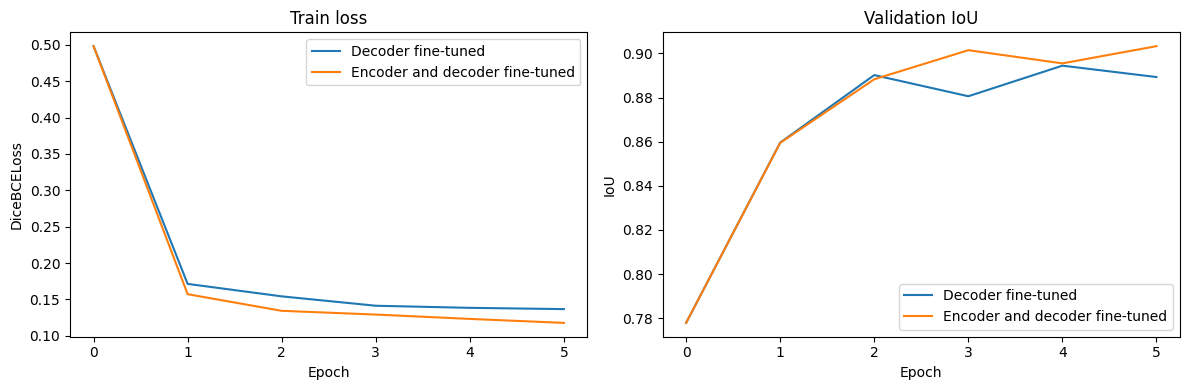

In [47]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

axes[0].set_title("Train loss")
axes[0].plot(decoder_finetuned_history["train_loss"], label = "Decoder fine-tuned")
axes[0].plot(more_finetuned_history["train_loss"], label = "Encoder and decoder fine-tuned")
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("DiceBCELoss")

axes[1].set_title("Validation IoU")
axes[1].plot(decoder_finetuned_history["val_iou"], label = "Decoder fine-tuned")
axes[1].plot(more_finetuned_history["val_iou"], label = "Encoder and decoder fine-tuned")
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")

plt.tight_layout()
plt.show()

Como é possível observar, ambos os experimentos de fine-tuning conseguiram melhorar o desempenho geral do modelo SAM original, tanto diminuindo sua perda no conjunto de treino quanto aumentando seu coeficiente IoU no conjunto de validação. Além disso, nota-se que o modelo com o decoder e o encoder fine-tunados obteve um desempenho levemente melhor que o modelo apenas com o decoder fine-tunado, indicando que o encoder daquele foi capaz de extrair características mais apropriadas para a nova tarefa e, com isso, entregar representações mais significativas para o decoder.

### Desempenho no conjunto de teste

A seguir, calculamos o coeficiente IoU de cada modelo no conjunto de teste.

In [50]:
# Movendo os modelos para a GPU
sam.to(device)
sam_decoder_finetuned.to(device)
sam_more_finetuned.to(device)

# Calculando o IoU de cada modelo no conjunto de teste
iou_original = validate_one_epoch(sam, test_loader, calculate_iou, device)
iou_decoder_finetuned = validate_one_epoch(sam_decoder_finetuned, test_loader, calculate_iou, device)
iou_more_finetuned = validate_one_epoch(sam_more_finetuned, test_loader, calculate_iou, device)

Validando: 100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


In [53]:
print("IoUs dos modelos no conjunto de teste:")
print("SAM original:                              ", iou_original)
print("SAM com o decoder fine-tunado:             ", iou_decoder_finetuned)
print("SAM com o encoder e o decoder fine-tunados:", iou_more_finetuned)

IoUs dos modelos no conjunto de teste:
SAM original:                               0.7721548009437974
SAM com o decoder fine-tunado:              0.8924921253323554
SAM com o encoder e o decoder fine-tunados: 0.8928992302715778


Observa-se que o processo de fine-tuning melhorou consideravelmente o desempenho do modelo SAM no conjunto de teste. Por outro lado, o ganho obtido pelo fine-tuning mais pesado em relação ao fine-tuning mais leve é mínimo. Isso pode ter acontecido por causa de overfitting desse modelo complexo no conjunto de treino, que contém apenas algumas milhares de imagens (uma quantidade pequena em comparação às milhões de imagens nas quais o SAM é originalmente treinado). Outra possibilidade é a qualidade do próprio ground truth, que, por ter possíveis ambiguidades entre dermatologistas, acaba limitando o desempenho do modelo.

### Resultados no conjunto de teste

Em seguida, exibiremos algumas previsões realizadas por cada um dos modelos em estudo para fins de comparação.

In [70]:
# Função para obter as predições dos modelos
def get_prediction_and_iou(model, image_tensor, mask_gt, box_tensor, device):
    mask_gt = mask_gt.to(device)

    # Predição para o SAM 2
    if isinstance(model, SAM2ImagePredictor):
        # Pré-processa a imagem
        img_np = denormalize_image(image_tensor)
        img_np = (img_np * 255).astype(np.uint8)
        # Configura a imagem
        model.set_image(img_np)
        box_np = box_tensor.cpu().numpy()

        # Faz a predição
        masks, _, _ = model.predict(
            point_coords = None,
            point_labels = None,
            box = box_np,
            multimask_output = False
        )

        pred_mask = torch.from_numpy(masks[0]).to(device).float()

    # Predição para o SAM 1
    else:
        model.eval()
    
        # Adicionando a dimensão de batch, se necessário
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        if box_tensor.dim() == 1:
            box_tensor = box_tensor.unsqueeze(0)
    
        image_tensor = image_tensor.to(device)
        box_tensor = box_tensor.to(device)
    
        with torch.no_grad():
            # Passando pelo image encoder
            image_embeddings = model.image_encoder(image_tensor)
            # Passando pelo prompt encoder
            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points = None,
                boxes = box_tensor.unsqueeze(1),
                masks = None,
            )
            # Passando pelo mask decoder
            low_res_masks, _ = model.mask_decoder(
                image_embeddings = image_embeddings,
                image_pe = model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings = sparse_embeddings,
                dense_prompt_embeddings = dense_embeddings,
                multimask_output = False
            )
    
            # Upscale
            upscaled_masks = F.interpolate(
                low_res_masks,
                size = (1024, 1024),
                mode = "bilinear",
                align_corners = False
            )
    
            # Obtendo a saída binária
            pred_mask = (torch.sigmoid(upscaled_masks) > 0.5).float()
            pred_mask = pred_mask.squeeze()
            
    # Calculando o IoU
    iou = calculate_iou(pred_mask, mask_gt)

    return pred_mask.squeeze().cpu().numpy(), iou

In [71]:
# Função para reverter a normalização para visualização
def denormalize_image(image_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)

    return img

In [72]:
# Função para plotar um grid de predições
def plot_comparison_grid(dataset, models_dict, num_samples = 3, device = device):
    # Selecionando imagens aleatórias
    indices = random.sample(range(len(dataset)), num_samples)

    cols = 2 + len(models_dict)
    rows = num_samples

    fig, axes = plt.subplots(rows, cols, figsize = (4 * cols, 4 * rows))

    if rows == 1:
        axes = axes.reshape(1, -1)

    # Para cada imagem...
    for row_idx, img_idx in enumerate(indices):
        # Pega a imagem do dataset
        image_tensor, mask_gt, box = dataset[img_idx]

        # Plota a imagem original na 1º coluna
        ax = axes[row_idx, 0]
        img_vis = denormalize_image(image_tensor)
        ax.imshow(img_vis)

        # Desenha a box
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill = False, edgecolor = "red", linewidth = 2)
        ax.add_patch(rect)
        ax.set_title(f"Input (img {img_idx})")
        ax.axis("off")

        # Plotando o ground truth na 2º coluna
        ax = axes[row_idx, 1]
        ax.imshow(mask_gt.squeeze(), cmap = "gray")
        ax.set_title("Ground truth")
        ax.axis("off")

        # Plotando os resultados dos modelos da 3º coluna em diante
        box_tensor = torch.tensor(box)

        # Para cada modelo...
        for model_idx, (model_name, model_obj) in enumerate(models_dict.items()):
            # Obtém a predição e o IoU
            pred_mask, iou = get_prediction_and_iou(
                model_obj, image_tensor, mask_gt, box_tensor, device
            )

            ax = axes[row_idx, 2 + model_idx]
            ax.imshow(pred_mask, cmap = "gray")

            ax.set_title(f"{model_name}\nIoU: {iou:.4f}", fontweight = "bold")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

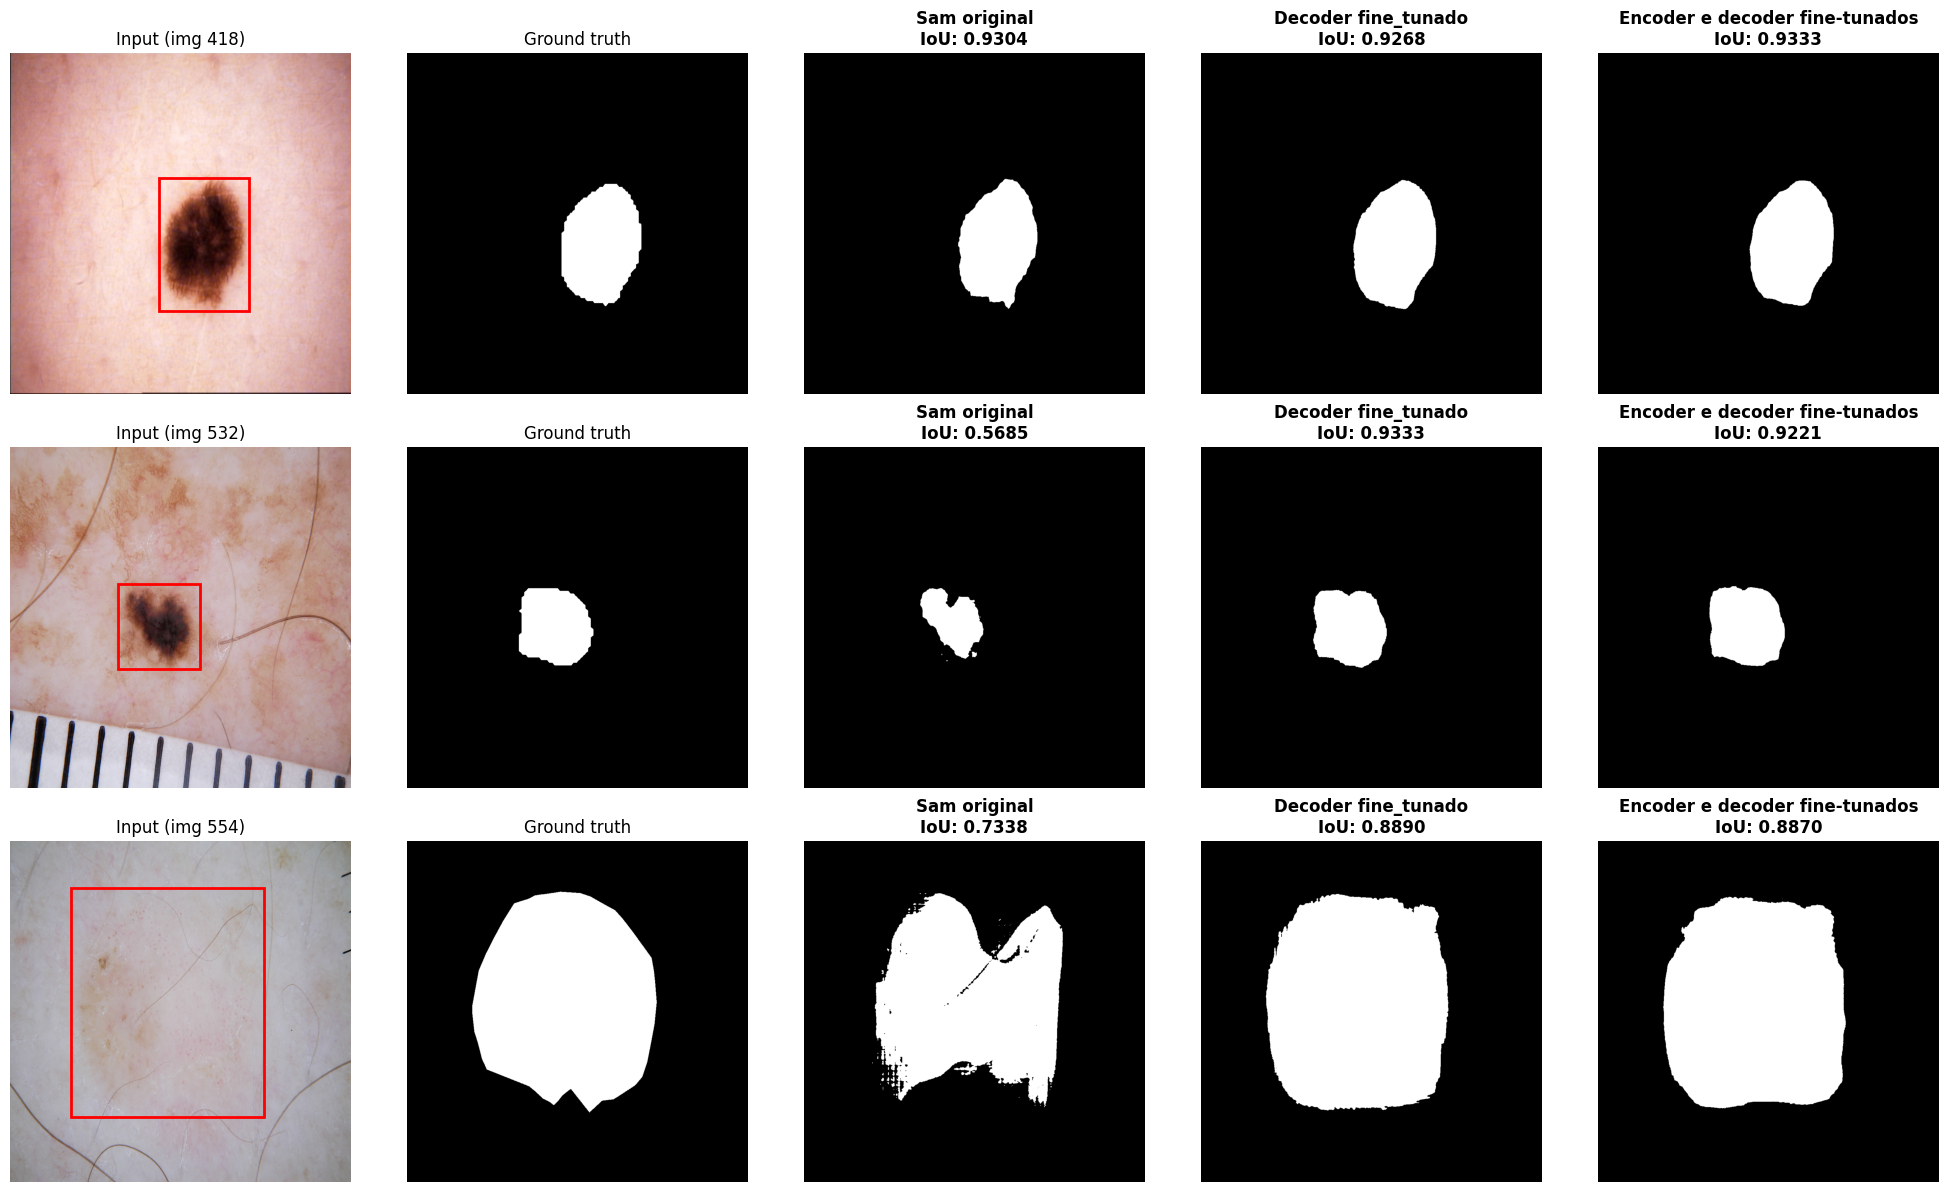

In [83]:
models_to_compare = {
    "Sam original": sam,
    "Decoder fine_tunado": sam_decoder_finetuned,
    "Encoder e decoder fine-tunados": sam_more_finetuned
}

plot_comparison_grid(test_ds, models_to_compare)

É evidente a adaptação do modelo aos dados de domínio médico. Enquanto o SAM original tende a ficar confuso com outros elementos da imagem (como pelos) e a falhar em bordas com baixo contraste, os modelos fine-tunados obtêm maior fidelidade ao ground truth, capturando com maior precisão as irregularidades e texturas finas das lesões.

### Extra: SAM 2

Por último, compararemos os resultados obtidos pelo fine-tuning da primeira versão do modelo SAM com as predições do modelo SAM 2 sem fine-tuning.

In [66]:
# Baixando o SAM 2
if not os.path.exists("/kaggle/working/sam2.1_hiera_tiny.pt"):
    !pip install -q git+https://github.com/facebookresearch/sam2.git
    !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
    !wget -q https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2.1/sam2.1_hiera_t.yaml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [68]:
# Carregando o SAM 2
checkpoint_path = "/kaggle/working/sam2.1_hiera_tiny.pt"
config_path = "configs/sam2.1/sam2.1_hiera_t.yaml"

# Build do modelo Tiny
sam2_model = build_sam2(config_path, checkpoint_path, device=device)

predictor_sam2 = SAM2ImagePredictor(sam2_model)

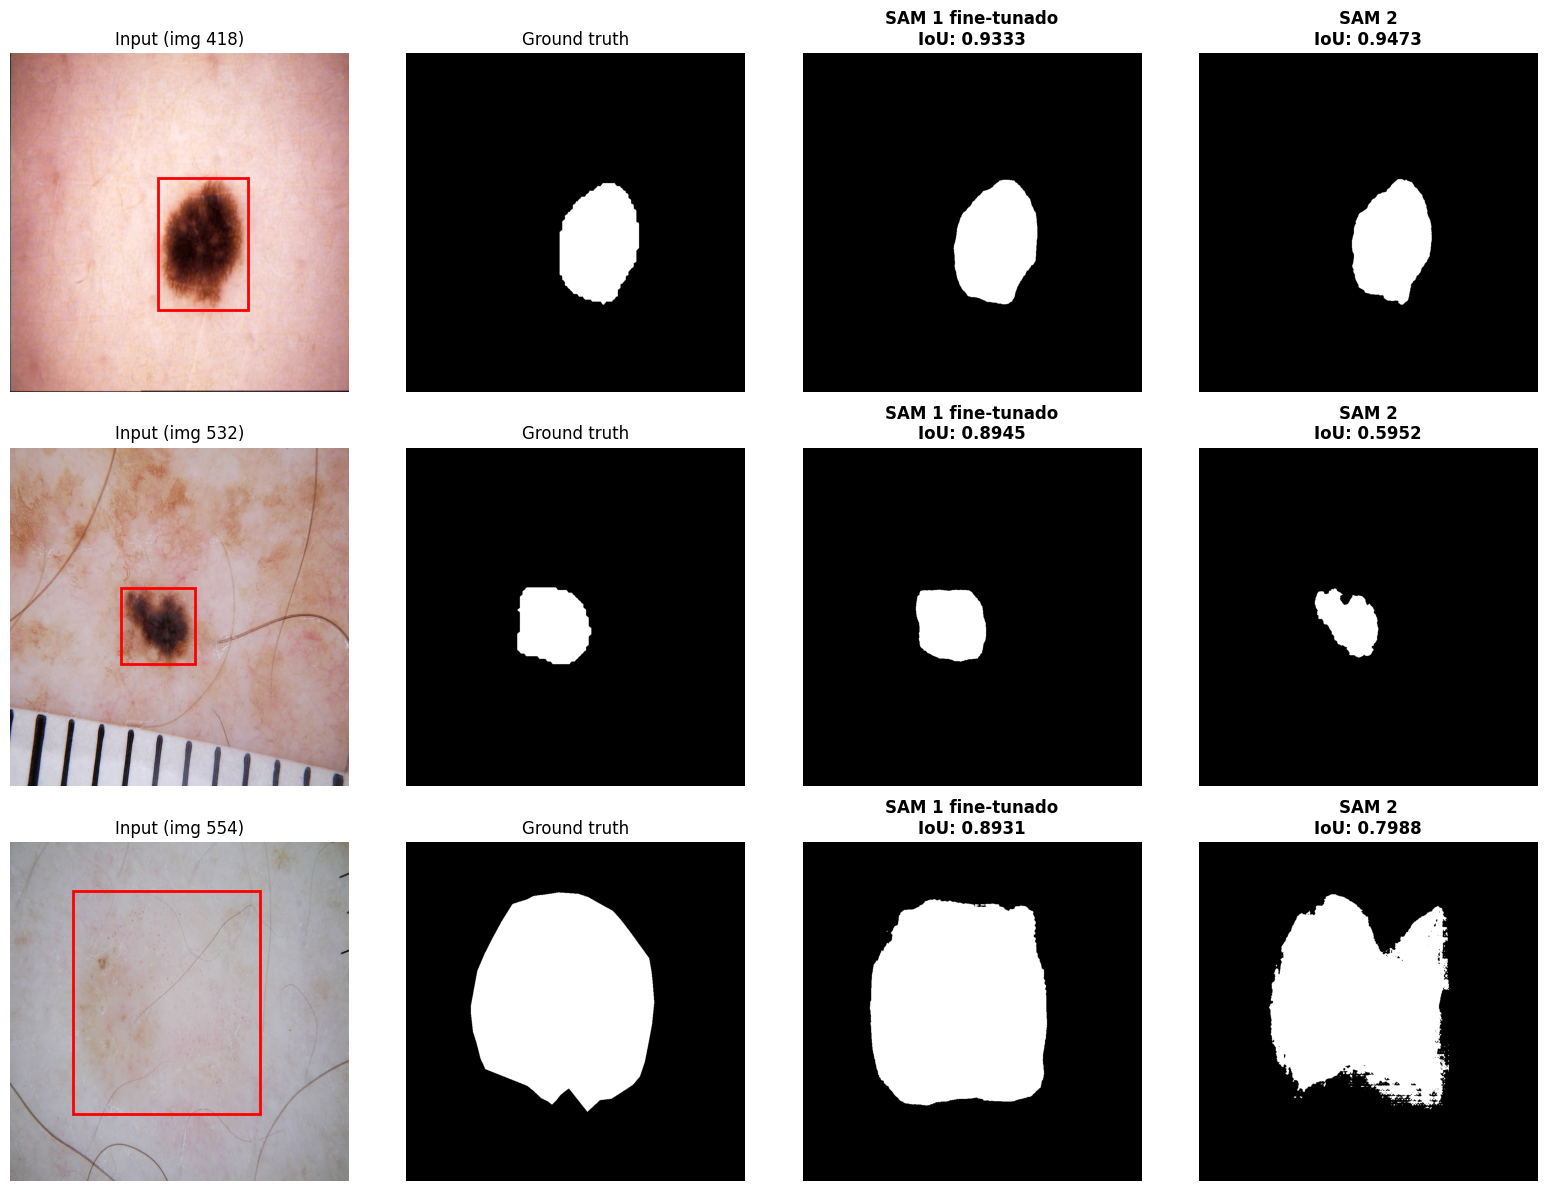

In [86]:
models_to_compare = {
    "SAM 1 fine-tunado": sam_more_finetuned,
    "SAM 2": predictor_sam2
}

plot_comparison_grid(test_ds, models_to_compare)

Embora o SAM 2 seja uma arquitetura mais eficiente, podemos observar que sua aplicação direta a esse problema não é adequada, com sua versão anterior com fine-tuning apresentando um desempenho superior. Assim, o fine-tuning mostra-se necessário para que o modelo seja exposto a dados específicos do domínio durante o treinamento.

## Conclusão

Portanto, a partir dos resultados observados, pode-se concluir que mesmo modelos poderosos como o SAM necessitam de processos de fine-tuning para atingir performances mais altas em domínios específicos. Foi mostrado que, mesmo quando comparado a um modelo de geração superior mas que nunca foi exposto aos dados do domínio, um modelo mais fraco treinado nesse conjunto pode obter um desempenho melhor.

O próximo passo lógico desse trabalho seria realizar o fine-tuning do modelo SAM 2, que provavelmente superaria os resultados do SAM 1 com fine-tuning. Mais ainda, isso poderia ser feito com o SAM 3, lançado no dia 19 de novembro de 2025. Durante o projeto, tentamos realizar a comparação de resultados também com o SAM 3 original. No entanto, isso foi impossibilitado por um problema de versão do Python: o ambiente do Kaggle, que utilizamos para esses experimentos, possui instalada a versão 3.10 da linguagem, mas o SAM 3 exige versão igual ou superior à 3.12.

Outro estudo possível seria com outras possibilidades de prompt: aqui, limitamos os experimentos a receberem bounding boxes como prompts, mas poderíamos ter utilizado apenas pontos de localização ou textos. Isso poderia ter feito o fine-tuning ser ainda mais impactante, dado que o encoder precisaria entender não quais pixels dentro da bounding box pertencem à lesão, mas até onde ela se estende a partir de um ponto dado.